### Timeseries forecast

Tha data contains information about the ammount of passangers in airplanes. The data is classified in date/time and the passangers travelling per month. We need to build a model to forecast the demand (passanger traffic).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [3]:
dataset = pd.read_csv('AirPassengers.csv')

#Parse strings to dataset type
dataset['TravelDate'] = pd.to_datetime(dataset['TravelDate'], infer_datetime_format=True)
indexedDataset = dataset.set_index(['TravelDate'])

In [4]:
from datetime import datetime
indexedDataset.head(5)

,Passengers
TravelDate,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
indexedDataset.tail(5)

,Passengers
TravelDate,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


We have data from 1949 to 1960.


Let's plot the graph

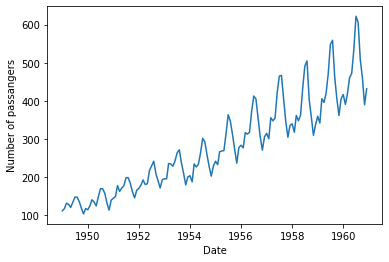

In [7]:
plt.xlabel('Date')
plt.ylabel("Number of passangers")
plt.plot(indexedDataset);

From the graph we can see that uor data is not stationary.

Let's check it.

In [8]:
#Determing of rolling statistics:
rolmean = indexedDataset.rolling(window=12).mean()

rolstd = indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)

            Passengers
TravelDate            
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01  463.333333
1960-09-01  467.083333
1960-10-01  471.583333
1960-11-01  473.916667
1960-12-01  476.166667

[144 rows x 1 columns]             Passengers
TravelDate            
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01   83.630500
1960-09-01   84.617276
1960-10-01   82.541954
1960-11-01   79.502382
1960-12-01   77.737125

[144 rows x 1 columns]


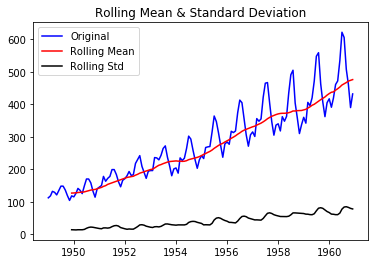

In [9]:
#plot rolling statistics:
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

 From this graph we can make a conclusion that because of The Rolling Mean and Rolling Std are not constant, our data is not stationary.

In [15]:
# Run Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test:')
dftest = adfuller(indexedDataset['Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s) '%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Our p-value should be always less, we obtained very large one (0.99). We havecritical value at different percentages. So we can not reject the null hypothesis. Our data is not stationary according to performed test.

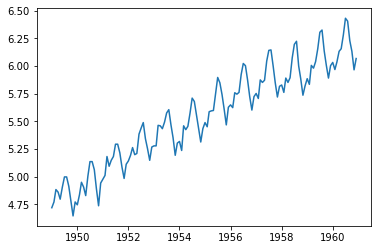

In [19]:
#Estimating the trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale);

Our indexed dataset is dataset with time as index.

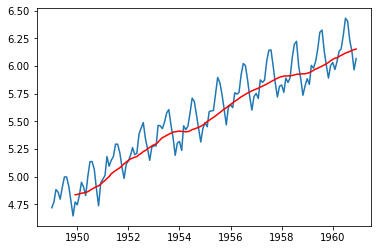

In [22]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()

movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red');

We can conclude from our graph that our mean is not stationary. We see the upward trend.

Next we will get the difference between the moving average and the actual number of passengers.

In [24]:
datasetLogScaleMinusMovingAvg = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAvg.head(12)

#Remove Non Values
datasetLogScaleMinusMovingAvg.dropna(inplace=True)
datasetLogScaleMinusMovingAvg.head(10)

,Passengers
TravelDate,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


In [25]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics:
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of DIckey-Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s) '%key] = value
    print(dfoutput)

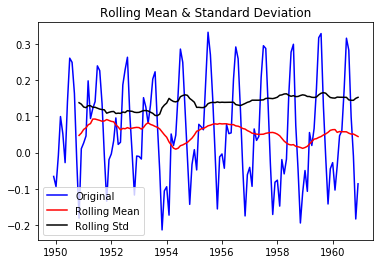

Results of DIckey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [27]:
test_stationarity(datasetLogScaleMinusMovingAvg);

There is no trend and it is much better than we saw earlier. 
From the results of Dickey-fuller test we can see that our p-values is 0.02, test statistics and critical value are almost equal.

We need to calculate the weighted average of timeseries, because we want to see the trend that is present inside a timeseries.

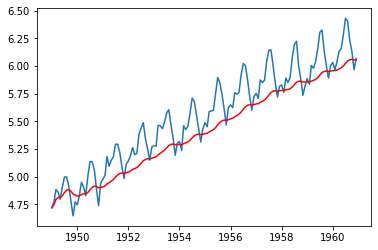

In [28]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red');

 We can see that our trend is upward and keepd increasing with respect to time.

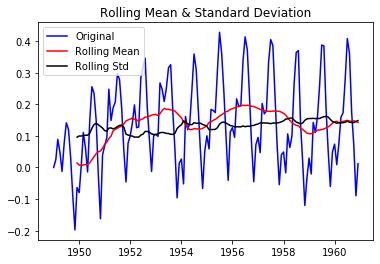

Results of DIckey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [29]:
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

Our rolling mean is better than previously, there is no trend also.
According to results of Dickey-Fuller test we gat: p-value = 0.006, whicn means that our timeseries is stationary.

Next we will shift the values into time series so we can use it in the forecasting.

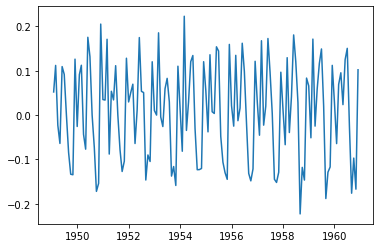

In [30]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting);

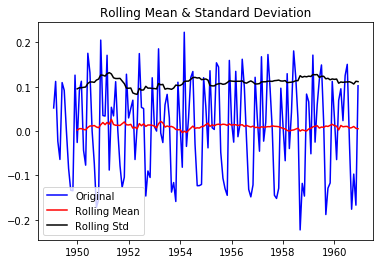

Results of DIckey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [31]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

We can see from the graph that our timeseries is stationary.

Let's see the components of timeseries.

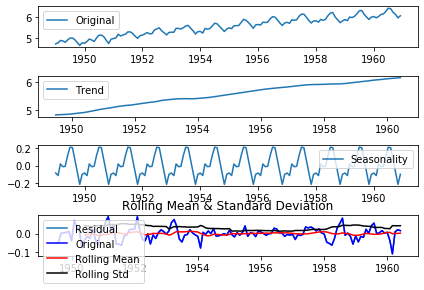

Results of DIckey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout();

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)

test_stationarity(decomposedLogData)

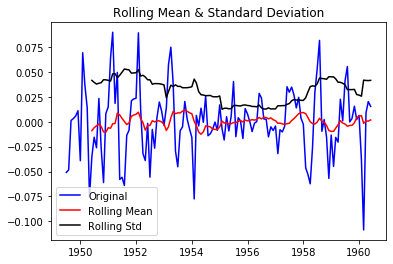

Results of DIckey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [37]:
# Check the noise whether it is stationary or not

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

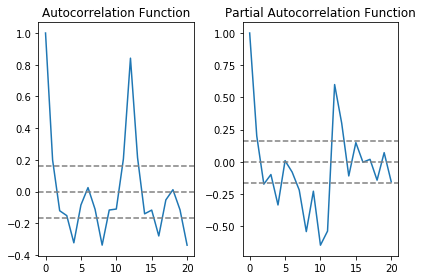

In [42]:
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

We need to find our P and Q values. 

If you check that what is the value where the graph cuts off,line touches 0 in the first graph at value around 2 (it is P parameter).

In the second graph line touches 0 at value around 2 also, so our Q parameter = 2.

C:\Users\elena-apelsinchik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\elena-apelsinchik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


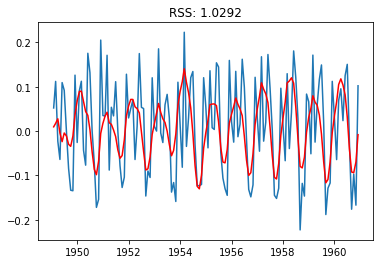

In [45]:
from statsmodels.tsa.arima_model import ARIMA

#AR model
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetLogDiffShifting['Passengers'])**2))
print('Plotting AR model');

C:\Users\elena-apelsinchik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\elena-apelsinchik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


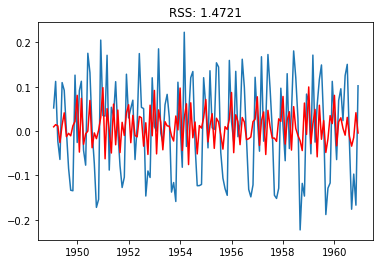

In [48]:
#MA Model"
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-datasetLogDiffShifting['Passengers'])**2))
print('Plotting AR model');

C:\Users\elena-apelsinchik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\elena-apelsinchik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


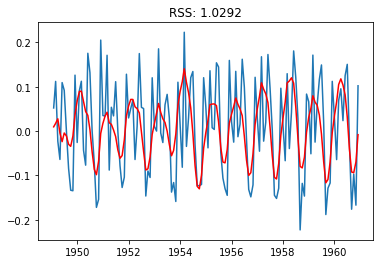

In [50]:
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting['Passengers'])**2))
print('Plotting AR model');

Let's do some fitting on the timeseries.

In [51]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

TravelDate
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [52]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

TravelDate
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [53]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Passengers'].ix[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

C:\Users\elena-apelsinchik\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


TravelDate
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

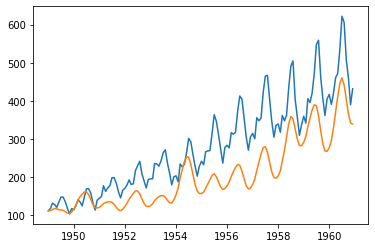

In [55]:
predictions_ARIMA= np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA);

In [56]:
indexedDataset_logScale

,Passengers
TravelDate,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


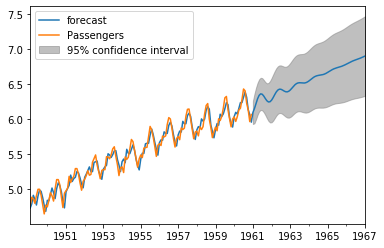

In [57]:
# prediction for the next 6 years:
results_ARIMA.plot_predict(1, 216)
x=results_ARIMA.forecast(steps=120)

In [58]:
results_ARIMA.forecast(steps=120)

(array([6.09553391, 6.15281403, 6.2244297 , 6.29241111, 6.3416473 ,
        6.36359377, 6.35784699, 6.33139313, 6.29597544, 6.26447712,
        6.2473832 , 6.25025165, 6.27275832, 6.30940312, 6.35151498,
        6.38988664, 6.41727392, 6.43011064, 6.42906696, 6.4184249 ,
        6.40456151, 6.39403607, 6.39183072, 6.40019494, 6.41833686,
        6.44295406, 6.46937438, 6.49293991, 6.51024124, 6.51989037,
        6.52267578, 6.52112382, 6.51864518, 6.51853678, 6.5231191 ,
        6.5332235 , 6.54812862, 6.56591553, 6.58410307, 6.60036539,
        6.61313265, 6.62192778, 6.62737782, 6.63093119, 6.63438676,
        6.63937971, 6.64696491, 6.65739828, 6.67015315, 6.68414243,
        6.6980662 , 6.71077894, 6.72157725, 6.73033974, 6.73749799,
        6.74386365, 6.75037307, 6.75782576, 6.76668666, 6.77699808,
        6.78841306, 6.80032841, 6.81207183, 6.82308748, 6.83307123,
        6.84202478, 6.85022296, 6.85811203, 6.86617322, 6.87479132,
        6.88416284, 6.89426366, 6.90487872, 6.91